In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from pydantic import parse_obj_as
from typing import List
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

import warnings
warnings.filterwarnings('ignore')

In [3]:
from sales_forecasting.api.model import RequestSchema
from sales_forecasting.utils.feature_engineering import calendar_features, incomplete_data_stores
from sales_forecasting.utils.ml import  results_df, results_keeper, final_results_keeper, prediction_metrics_and_result_keeper, smape, error, store_train_test_selection, model_selection_specific_store, train_test_validate_split_on_date, predicted_vs_real_plot
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

In [4]:
models=[]
daily_smape=[]
weekly_smape=[]
monthly_smape=[]
percentage_error_model=[]
list_of_incomplete_stores=[]
store=[]


In [5]:
raw_sales_data = pd.read_csv('../data/sales_per_store_per_day.csv', 
    dtype={'Store':'Int64','DayOfWeek':'Int64','Sales':'Int64','Customers':'Int64','Open':'Int64','Promo':'Int64','StateHoliday':'str','SchoolHoliday':'Int64'}, parse_dates=['Date'])

raw_dict=raw_sales_data.to_dict(orient='records')
validated_sales=parse_obj_as(List[RequestSchema], raw_dict)

del raw_sales_data, raw_dict
gc.collect()

sales_df=pd.DataFrame([item.dict() for item in validated_sales])
del validated_sales 
gc.collect()

0

## Feature engineering

In [6]:
sales_df['sales_date'] = pd.to_datetime(sales_df['sales_date'])
sales_df['close_flag'] = np.where(sales_df['open_flag'] == 1, 0, 1)
sales_df['state_holiday_flag']=np.where(sales_df['state_holiday'] == '0', 0, 1)
sales_df = calendar_features(sales_df)
sales_df['week_of_year'] = sales_df['week_of_year'].astype(int)

In [7]:
sales_df

,sales_date,store,sales,customers,open_flag,promo,day_of_week,state_holiday,school_holiday,close_flag,state_holiday_flag,year,month,day_of_month,day_of_year,week_of_year,odd_weeks
0,2015-06-30,1,5735,568,1,1,2,0,0,0,0,2015,6,30,181,27,1
1,2015-06-30,2,9863,877,1,1,2,0,0,0,0,2015,6,30,181,27,1
2,2015-06-30,3,13261,1072,1,1,2,0,1,0,0,2015,6,30,181,27,1
3,2015-06-30,4,13106,1488,1,1,2,0,0,0,0,2015,6,30,181,27,1
4,2015-06-30,5,6635,645,1,1,2,0,0,0,0,2015,6,30,181,27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982639,2013-01-01,1111,0,0,0,0,2,a,1,1,1,2013,1,1,1,1,1
982640,2013-01-01,1112,0,0,0,0,2,a,1,1,1,2013,1,1,1,1,1
982641,2013-01-01,1113,0,0,0,0,2,a,1,1,1,2013,1,1,1,1,1
982642,2013-01-01,1114,0,0,0,0,2,a,1,1,1,2013,1,1,1,1,1


### Explore Machine Learning models on one store

In [8]:
one_store = sales_df[sales_df['store']==85].copy()
x_train, y_train, x_test, y_test, x_validate, y_validate = train_test_validate_split_on_date(one_store.drop(columns=['store','customers','state_holiday']), datetime(2015,3,1), datetime(2015,5,1), datetime_col='sales_date', output_col='sales')

## LGBMRegressor

Total value of sales on test predicted interval: 462814
Absolute error:  64513
Percentage error reported to real sales: 3.15%
Daily SMAPE is: 13.45 %
Weekly SMAPE is: 7.31 %
Monthly SMAPE is: 9.0 %


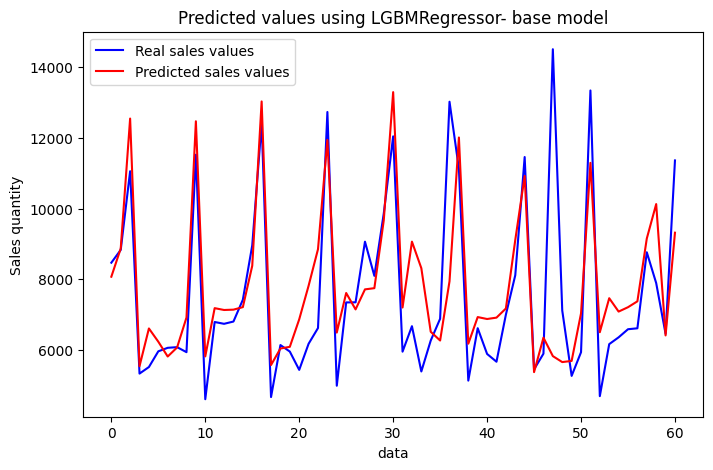

In [9]:
EXPERIMENT_NAME = "sales_forecasting"
EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)
with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name='base_model_2') as run:
    RUN_ID = run.info.run_id
    model = LGBMRegressor()
    model = model.fit(x_train, y_train)
    y_pred_lgb = model.predict(x_test)
    models, daily_smape, weekly_smape, monthly_smape, percentage_error_model=prediction_metrics_and_result_keeper(y_test, y_pred_lgb, model)
    predicted_vs_real_plot(y_test, y_pred_lgb, title='Predicted values using LGBMRegressor- base model', image_name='real_vs_predicted')
    
    mlflow.log_metric('daily_smape', daily_smape[-1])
    mlflow.log_metric('weekly_smape', weekly_smape[-1])
    mlflow.log_metric('monthly_smape', monthly_smape[-1])
    mlflow.lightgbm.log_model(model, 'model')
    mlflow.log_artifact("real_vs_predicted.png")

## Hyperparameter optimization using Optuna

In [10]:
import optuna
from sklearn.metrics import mean_squared_error

def objective_lgbm(trial,x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test):
    param = {
        'metric': 'rmse', 
        'random_state': 1,
        'objective':'regression',
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 50.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 50.0),
        'colsample_bytree': trial.suggest_loguniform("colsample_bytree", 0.1, 1.0),
        'subsample': trial.suggest_loguniform("subsample", 0.1, 1.0),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1.0),
        'max_depth': trial.suggest_int("max_depth", 1, 40),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 40),
        'min_child_samples': trial.suggest_int('min_child_samples',3, 300)
    }
    model = LGBMRegressor(**param)  
    model.fit(x_train,y_train,eval_set=[(x_validate,y_validate)],early_stopping_rounds=100,verbose=False)
    preds = model.predict(x_validate)
    rmse = mean_squared_error(y_validate, preds,squared=False)
    
    return rmse
study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=200)
print('Number of finished trials:', len(study_lgbm.trials))
print('Best trial:', study_lgbm.best_trial.params)
best_lgbm_params=study_lgbm.best_params

[I 2023-05-17 13:50:11,807] A new study created in memory with name: no-name-a7b5c0fa-90b7-4794-b974-df020d7af0ce
[I 2023-05-17 13:50:11,916] Trial 0 finished with value: 2452.8606446169347 and parameters: {'n_estimators': 664, 'reg_alpha': 0.001569338188784774, 'reg_lambda': 4.382215420762701, 'colsample_bytree': 0.36994141581433, 'subsample': 0.7692965443829669, 'learning_rate': 1.984767616858549e-08, 'max_depth': 32, 'num_leaves': 2, 'min_child_samples': 176}. Best is trial 0 with value: 2452.8606446169347.
[I 2023-05-17 13:50:11,950] Trial 1 finished with value: 2342.961531896834 and parameters: {'n_estimators': 178, 'reg_alpha': 0.0061878997884867925, 'reg_lambda': 0.3191141457877057, 'colsample_bytree': 0.9695636763819508, 'subsample': 0.14904903217523013, 'learning_rate': 0.029348369065229547, 'max_depth': 32, 'num_leaves': 30, 'min_child_samples': 273}. Best is trial 1 with value: 2342.961531896834.
[I 2023-05-17 13:50:12,028] Trial 2 finished with value: 2429.9149900945445 and

Number of finished trials: 200
Best trial: {'n_estimators': 596, 'reg_alpha': 0.0012563144726040697, 'reg_lambda': 0.2071591501326066, 'colsample_bytree': 0.2542639085284935, 'subsample': 0.7643373485966213, 'learning_rate': 0.34037968175766603, 'max_depth': 17, 'num_leaves': 5, 'min_child_samples': 3}


Total value of sales on test predicted interval: 462814
Absolute error:  57541
Percentage error reported to real sales: 9.36%
Daily SMAPE is: 12.49 %
Weekly SMAPE is: 9.63 %
Monthly SMAPE is: 7.72 %


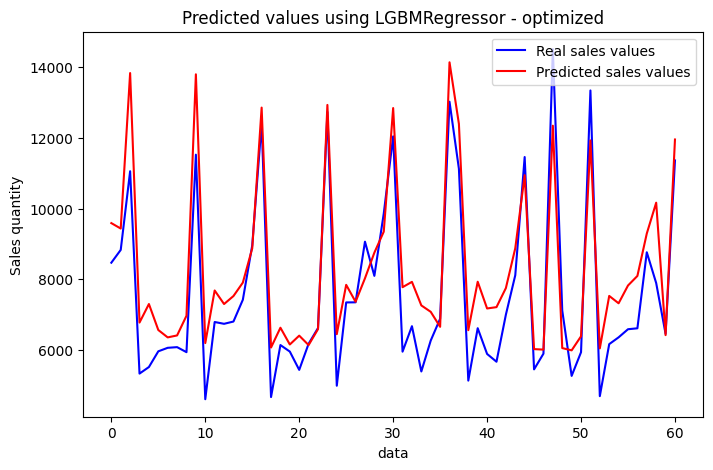

In [11]:
with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name='optimized_lgbm') as run:
    RUN_ID = run.info.run_id
    model = LGBMRegressor()
    model.set_params(**best_lgbm_params)
    model = model.fit(x_train, y_train)
    y_pred_lgb = model.predict(x_test)
    models, daily_smape, weekly_smape, monthly_smape, percentage_error_model=prediction_metrics_and_result_keeper(y_test, y_pred_lgb, model)
    mlflow.log_metric('daily_smape', daily_smape[-1])
    mlflow.log_metric('weekly_smape', weekly_smape[-1])
    mlflow.log_metric('monthly_smape', monthly_smape[-1])
    mlflow.lightgbm.log_model(model, 'model')

    predicted_vs_real_plot(y_test, y_pred_lgb, title='Predicted values using LGBMRegressor - optimized', image_name='real_vs_predicted_lgbm_final')
    mlflow.log_artifact("real_vs_predicted_lgbm_final.png")

## RandomForestRegressor

In [12]:
def objective_rf(trial,x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test):
    
    param = {
        'random_state': 1,
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 2, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 8),
        'max_features': trial.suggest_int('max_features', 1, 12)
    }
    model = RandomForestRegressor(**param)  
    model.fit(x_train,y_train)
    preds = model.predict(x_validate)
    rmse = mean_squared_error(y_validate, preds, squared=False)
    
    return rmse
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=200)
print('Number of finished trials:', len(study_rf.trials))
print('Best trial:', study_rf.best_trial.params)
best_rf_params=study_rf.best_params

[I 2023-05-17 13:51:33,696] A new study created in memory with name: no-name-95d7ba94-33af-4f3a-80d4-24dbb7b7884d
[I 2023-05-17 13:51:34,369] Trial 0 finished with value: 1254.0532316979384 and parameters: {'n_estimators': 308, 'max_depth': 18, 'min_samples_leaf': 10, 'min_samples_split': 7, 'max_features': 10}. Best is trial 0 with value: 1254.0532316979384.
[I 2023-05-17 13:51:35,732] Trial 1 finished with value: 1454.7019007656884 and parameters: {'n_estimators': 826, 'max_depth': 12, 'min_samples_leaf': 19, 'min_samples_split': 5, 'max_features': 10}. Best is trial 0 with value: 1254.0532316979384.
[I 2023-05-17 13:51:37,202] Trial 2 finished with value: 1463.5222874581225 and parameters: {'n_estimators': 857, 'max_depth': 20, 'min_samples_leaf': 18, 'min_samples_split': 7, 'max_features': 9}. Best is trial 0 with value: 1254.0532316979384.
[I 2023-05-17 13:51:38,856] Trial 3 finished with value: 1327.891268878375 and parameters: {'n_estimators': 930, 'max_depth': 18, 'min_samples_

Number of finished trials: 200
Best trial: {'n_estimators': 394, 'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 2, 'max_features': 12}


Total value of sales on test predicted interval: 462814
Absolute error:  36562
Percentage error reported to real sales: 1.6%
Daily SMAPE is: 7.91 %
Weekly SMAPE is: 4.39 %
Monthly SMAPE is: 2.83 %


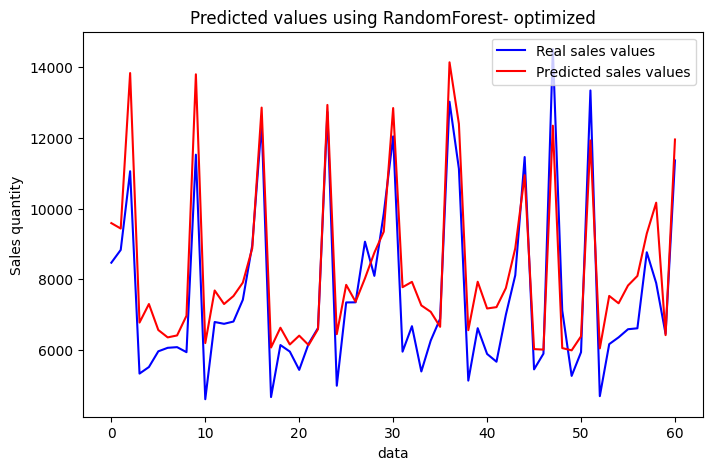

In [13]:
with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name='optimized_rf') as run:
    # Retrieve run id
    RUN_ID = run.info.run_id
    model = RandomForestRegressor(**best_rf_params)
    model = model.fit(x_train, y_train)
    y_pred_rf = model.predict(x_test)
    models, daily_smape, weekly_smape, monthly_smape, percentage_error_model=prediction_metrics_and_result_keeper(y_test, y_pred_rf, model)
    mlflow.log_metric('daily_smape', daily_smape[-1])
    mlflow.log_metric('weekly_smape', weekly_smape[-1])
    mlflow.log_metric('monthly_smape', monthly_smape[-1])
    mlflow.sklearn.log_model(model, 'model')

    plt.figure(figsize=(8,5))  
    plt.plot(y_test.values, color='blue', label='Real sales values')  
    plt.plot(y_pred_lgb , color='red', label='Predicted sales values')  
    plt.title('Predicted values using RandomForest- optimized')  
    plt.xlabel('data')  
    plt.ylabel('Sales quantity')  
    plt.legend()
    plt.savefig("real_vs_predicted.png")  
    plt.show()
    mlflow.log_artifact("real_vs_predicted.png")

## Comparative results

In [14]:
# create a model selection dataframe for best model determination
models[0] = 'LGBMRegressor - base'
model_selection = pd.DataFrame({'Model': models, 'daily_smape': daily_smape, 'weekly_smape': weekly_smape, 'monthly_smape' :monthly_smape, 'percentage_error': percentage_error_model})
model_selection.sort_values(by=['daily_smape'], ascending=False, inplace=True)
cmg = sns.light_palette("green", as_cmap=True)
model_selection.style.set_caption('Model Selection').background_gradient(cmap=cmg.reversed())

,Model,daily_smape,weekly_smape,monthly_smape,percentage_error
0,LGBMRegressor - base,13.450000,7.310000,9.000000,3.150000
1,LGBMRegressor,12.490000,9.630000,7.720000,9.360000
2,RandomForestRegressor,7.910000,4.390000,2.830000,1.600000
